# FEniCS simulation of Eshelby's circular inclusion problem

The aim of this notebook is to setup a FEniCS simulation of Eshelby's inclusion problem. The framework is linear, plane strain elasticity. We have a matrix in a disk around the origin (radius $R_m$) with an inclusion having the shape of another disk around the origin, with a smaller radius ($R_i < R_m$). The matrix and the inclusion have different elastic modulus ($E$: Young modulus; $\nu$: Poisson ratio) but are both isotropic and linearly elastic:

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the plane strain Lamé coefficients :

\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1,x_2)|_{x_1^2+x_2^2=R_m^2}
%\text{border}
=(x_2,x_1)\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
-\int_{\Omega} b \cdot v\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where the body force $b=0$ and $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

![shema](inclusion_shear.png)

In [1]:
!which python

/Users/baptistefraisse/opt/anaconda3/envs/fenicsproject/bin/python


In [860]:
import dolfin
from dolfin import *
import matplotlib.pyplot as plt
import mshr
import numpy as np

## Parameters of the simulation

### Geometric parameters

In [861]:
R_in = 1.0 # radius of the inclusion
R_out = 3.0 # radius of the outter matrix

### Material parameters

In [862]:
E_m = 1.0 # Young's modulus for the matrix
nu_m = -0.999999 #0.499999999 #0.3 # Poisson ratio for the matrix
E_i = 10.0 # Young's modulus for the inclusion
nu_i = -0.999999 #0.499999999 #0.3 # Poisson ratio for the inclusion

### Parameters of the finite element discretization

In [863]:
h = 0.03*R_in # Size of elements
degreeFE = 1 # Degree of the finite elements

In [864]:
ONE = dolfin.Constant(1.)

MATRIX_ID = 1
INCLUSION_ID = 2

## Generation of the mesh

The discretization of the geometric primitives (ellipse, circle) are defined in terms of number of segments. As we want to control the *size* of the elements, we need to compute the perimeter of the entities first.

In [865]:
L_in = 2*np.pi*R_in # perimeter of the inclusion
L_out = 2*np.pi*R_out # perimeter of the matrix

N_in = int(L_in/h) # number of mesh points on the perimeter 
                   # of the inclusion
N_out = int(L_out/h) # number of mesh points on the perimeter 
                     # of the matrix

In [866]:
N_in,N_out

(209, 628)

In [867]:
origin = dolfin.Point(0., 0.)

Omega_i = mshr.Circle(origin, R_in, segments=N_in)
Omega = mshr.Circle(origin, R_out, segments=N_out)

In [868]:
Omega.set_subdomain(MATRIX_ID, Omega-Omega_i) # we are putting tags in parts of the mesh
Omega.set_subdomain(INCLUSION_ID, Omega_i)    # we will use them later

In [869]:
mesh = mshr.generate_mesh(Omega, resolution=2*R_out/h)

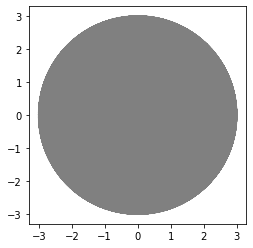

In [870]:
dolfin.plot(mesh)

### Integration over 2D subdomains

In [871]:
# we define a function = 1 in the matrix and = 2 in the inclusion
subdomain_data_2d = dolfin.MeshFunction("size_t", # the function returns a positive integer
                                        mesh, # it is define over the entire mesh
                                        dim=2, # the function is defined on the cells (not edges nor vertices)
                                        value=mesh.domains() # the function value is in fact
                                                             # given by the tag we have put while creating the mesh
                                       ) 

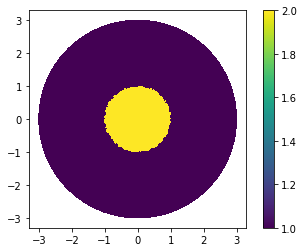

In [872]:
plt.colorbar(dolfin.plot(subdomain_data_2d)) # we plot this function, note the added color scale on the side

In [873]:
# we need to be able to integrate over the matrix only or the inclusion only
# so in addition of the classical dolfin measure dx, we define dx(1) and dx(2)
dx = dolfin.Measure("dx", domain=mesh, subdomain_data=subdomain_data_2d)

Here is how to integrate on a subdomain (we integrate the constant 1, so we obtain the area of each subdomain).

In [874]:
# area of the global mesh
dolfin.assemble(ONE*dx)

28.273862167611586

In [875]:
# area of the inclusion
dolfin.assemble(ONE*dx(INCLUSION_ID))

3.141119452036801

In [876]:
# area of the matrix
dolfin.assemble(ONE*dx(MATRIX_ID))

25.132742715574683

# Questions start here !

# you will have to fill missing items in the following code

## Constitutive law

Rather than the Young modulus $E$ and Poisson ratio $\nu$, we will use the Lamé coefficients $\lambda$ and $\mu$ to define the constitutive law.
We compute the numerical values of the Lamé coefficients of the inclusion and of the matrix 

Plane strain elasticity
\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

# 1) Define Lamé coefficients for both the inclusion and the matrix

In [877]:
mu_m = E_m/(2*(1+nu_m))
lamb_m = 2*mu_m*nu_m/(1-2*nu_m)
mu_i = E_i/(2*(1+nu_i))
lamb_i = 2*mu_i*nu_i/(1-2*nu_i)
print('mu_m =',mu_m)
print('lamb_m =',lamb_m)
print('mu_i =',mu_i)
print('lamb_i =',lamb_i)

mu_m = 499999.9999856222
lamb_m = -333333.222212563
mu_i = 4999999.9998562215
lamb_i = -3333332.2221256294


# 2) Write down Hook's law 

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

In [878]:
# sigma(eps)
def stress(eps, lamb, mu):
    return(lamb*tr(eps)*Identity(2) + 2.0*mu*eps)

# 3) Define the strain-displacement operator
$\varepsilon(u)=\mathrm{sym} (\nabla u)$ 

In [879]:
# eps(u)
def strain(d):
    return (sym(grad(d)))

## 4) Write down the Finite element discretization of the elasticity problem

In [880]:
element = dolfin.VectorElement('P', 
                               cell = dolfin.triangle, 
                               degree = degreeFE, 
                               dim = 2)
V = dolfin.FunctionSpace(mesh, element)
W = dolfin.FunctionSpace(mesh, element)

In [881]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

# 5) Write down the bilinear form

\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y
\end{equation}

In [882]:
# The system comprises two subdomains
# The total bilinear form is the addition of integrals on each subdomain

eps_u = strain(u)
eps_v = strain(v)
sig_i = stress(eps_u,lamb_i,mu_i)
sig_m = stress(eps_u,lamb_m,mu_m)

a_i = dolfin.inner(sig_i, eps_v)*dx(INCLUSION_ID)
a_m = dolfin.inner(sig_m, eps_v)*dx(MATRIX_ID)

bilinear_form = a_i + a_m

# 6) Write down the linear form

\begin{equation}
\int_{\Omega} b \cdot v\,\mathrm{d} x\,\mathrm{d} y \text{ with b=0}
\end{equation}

In [883]:
b = dolfin.Constant((0.,0.))

linear_form = dolfin.dot(b, v)*dolfin.dx

#linear_form = 0.0

# 7)Write down boundary conditions

$u(x_1,x_2)=(x_2,x_1)$ for $(x_1,x_2)$ such that $x_1^2 + x_2^2 = R_m^2$

In [884]:
u_BC = dolfin.Expression(("x[1]","x[0]"), degree=2)

class contour(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary

boundary_conditions = dolfin.DirichletBC(V, u_BC, contour())

## 8) Compute the Solution to the elasticity problem

In [885]:
# we note usol the solution
usol = dolfin.Function(V)

In [886]:
dolfin.solve(bilinear_form == linear_form, usol, boundary_conditions)

# 9) Plot the solution 

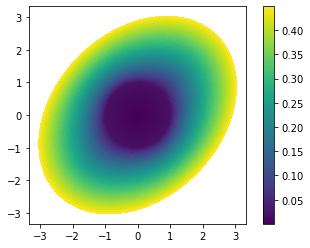

In [887]:
#c=dolfin.plot(usol)
#c=dolfin.plot(usol[0])
#c=dolfin.plot(usol[1])
#c=dolfin.plot(sqrt(usol[0]*usol[0]+usol[1]*usol[1]))
c=dolfin.plot(0.15*usol, mode="displacement")
plt.colorbar(c)

# We now consider the strain tensor of the solution

In [888]:
eps = dolfin.sym(dolfin.grad(usol))

## We want to plot eps_xx, eps_yy, eps_xy using the dolfin.plot() command but eps has no FunctionSpace, so we need to define one and dolfin.project() each of the four tensor components of eps on this new function space and then plot it with the dolfin.plot() command

## 10) Compare the strains in the inclusion with the strains in the matrix: are they uniform? What are the dominant components?

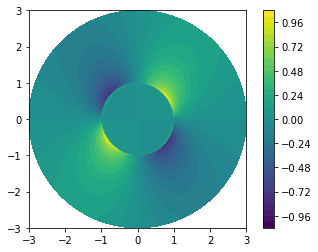

In [889]:
E = TensorFunctionSpace(mesh, "DG", degree=0)
strain = dolfin.project(eps,E)
#c=dolfin.plot(strain[0,0])
#c=dolfin.plot(strain[0,1])
#c=dolfin.plot(strain[1,0])
c=dolfin.plot(strain[1,1])
plt.colorbar(c)

# 11)Compute average strains 

\begin{equation}
<\sigma_{ij}>=\frac{\int_\Omega \sigma_{ij}\,\mathrm{d}x\,\mathrm{d}y }{ \int_\Omega 1 \, \mathrm{d}x\,\mathrm{d}y }
\end{equation}

# over the matix subdomain and the inclusion subdomain

In [890]:
S_i = TensorFunctionSpace(mesh, "DG", degree=0)
S_m = TensorFunctionSpace(mesh, "DG", degree=0)

epsilon_i = dolfin.project(eps,S_i)
epsilon_m = dolfin.project(eps,S_m)

av_strain_i_11 = (dolfin.assemble(epsilon_i[0,0]*dx(INCLUSION_ID))) / (dolfin.assemble(ONE*dx(INCLUSION_ID)))
av_strain_i_12 = (dolfin.assemble(epsilon_i[0,1]*dx(INCLUSION_ID))) / (dolfin.assemble(ONE*dx(INCLUSION_ID)))
av_strain_i_21 = (dolfin.assemble(epsilon_i[1,0]*dx(INCLUSION_ID))) / (dolfin.assemble(ONE*dx(INCLUSION_ID)))
av_strain_i_22 = (dolfin.assemble(epsilon_i[1,1]*dx(INCLUSION_ID))) / (dolfin.assemble(ONE*dx(INCLUSION_ID)))

av_strain_m_11 = (dolfin.assemble(epsilon_m[0,0]*dx(MATRIX_ID))) / (dolfin.assemble(ONE*dx(MATRIX_ID)))
av_strain_m_12 = (dolfin.assemble(epsilon_m[1,0]*dx(MATRIX_ID))) / (dolfin.assemble(ONE*dx(MATRIX_ID)))
av_strain_m_21 = (dolfin.assemble(epsilon_m[0,1]*dx(MATRIX_ID))) / (dolfin.assemble(ONE*dx(MATRIX_ID)))
av_strain_m_22 = (dolfin.assemble(epsilon_m[1,1]*dx(MATRIX_ID))) / (dolfin.assemble(ONE*dx(MATRIX_ID)))

print("<eps_i> =", av_strain_i_11, av_strain_i_12, av_strain_i_21, av_strain_i_22)
print("<eps_m> =", av_strain_m_11, av_strain_m_12, av_strain_m_21, av_strain_m_22)

<eps_i> = -5.434125947208846e-08 0.1256745201505537 0.1256745201505537 -3.834261250291441e-08
<eps_m> = 6.791633904548687e-09 1.1092742166363174 1.1092742166363174 4.792104353795122e-09


# 12)Show that the shear strain in the inclusion is 'almost' uniform. Quantify the term 'almost' by computing

\begin{equation}
deviation = \frac{\int_\Omega Abs(\sigma_{ij} - <\sigma_{ij}>) \,\mathrm{d}x\,\mathrm{d}y }{ <\sigma_{ij}> }
\end{equation}

In [891]:
deviation_11 = (dolfin.assemble(abs(epsilon_i[0,0]-av_strain_i_11)*dx(INCLUSION_ID))) / av_strain_i_11
deviation_12 = (dolfin.assemble(abs(epsilon_i[1,0]-av_strain_i_12)*dx(INCLUSION_ID))) / av_strain_i_12
deviation_21 = (dolfin.assemble(abs(epsilon_i[0,1]-av_strain_i_21)*dx(INCLUSION_ID))) / av_strain_i_21
deviation_22 = (dolfin.assemble(abs(epsilon_i[1,1]-av_strain_i_22)*dx(INCLUSION_ID))) / av_strain_i_22

print(deviation_11, deviation_12, deviation_21, deviation_22)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-34218.14321663229 0.0039019373311592834 0.0039019373311592834 -48490.448472373384


# 13)Does $<\sigma_{xy}>$ follow the formula of the Hill tensor?

# Comparison with exact solution

The closed-form expression of the solution is derived in the companion notebook *Circular inhomogeneity — Shear*. This solution is implemented in the module `eshelby`, that can be imported. It builds the exact displacement field as a `dolfin.Expression`, which will allow easy comparison with the approximate solution found here.

In [892]:
class EshelbyDisk:
    def __init__(self, gamma, khi, nu_i, nu_m):
        self.gamma = gamma
        self.khi = khi
        self.nu_i = nu_i
        self.nu_m = nu_m

    def create_lhs(self):
        return np.array(
            [
                [2, 2 * self.gamma ** 2, 2 * self.gamma ** 4, 2 * self.gamma ** 6, 0, 0],
                [
                    2 * self.nu_m * (self.nu_m - 1),
                    -(self.gamma ** 2) * self.nu_m * (2 * self.nu_m - 1),
                    -2 * self.gamma ** 4 * self.nu_m * (self.nu_m - 1),
                    self.gamma ** 6 * (self.nu_m - 1) * (2 * self.nu_m - 3),
                    0,
                    0,
                ],
                [1, 1, 1, 1, -1, -1],
                [
                    2 * self.nu_i * self.nu_m * (self.nu_m - 1),
                    -self.nu_i * self.nu_m * (2 * self.nu_m - 1),
                    -2 * self.nu_i * self.nu_m * (self.nu_m - 1),
                    self.nu_i * (self.nu_m - 1) * (2 * self.nu_m - 3),
                    2 * self.nu_i * self.nu_m * (self.nu_m - 1),
                    -self.nu_m * (2 * self.nu_i - 3) * (self.nu_m - 1),
                ],
                [
                    3 * (self.nu_i + 1) * (self.nu_m - 1),
                    -self.nu_i - 1,
                    -(self.nu_i + 1) * (self.nu_m - 1),
                    0,
                    self.khi * (self.nu_m - 1) * (self.nu_m + 1),
                    0,
                ],
                [
                    -6 * self.nu_i * self.nu_m * (self.nu_i + 1) * (self.nu_m - 1),
                    self.nu_i * self.nu_m * (self.nu_i + 1),
                    -2 * self.nu_i * self.nu_m * (self.nu_i + 1) * (self.nu_m - 1),
                    -3 * self.nu_i * (self.nu_i + 1) * (self.nu_m - 1),
                    2 * self.khi * self.nu_i * self.nu_m * (self.nu_m - 1) * (self.nu_m + 1),
                    3 * self.khi * self.nu_m * (self.nu_m - 1) * (self.nu_m + 1),
                ],
            ]
        )

    def create_rhs(self):
        return np.array(
            [2 * self.gamma ** 4, -2 * self.gamma ** 4 * self.nu_m * (self.nu_m - 1), 0, 0, 0, 0]
        )

    def compute_integration_constants(self):
        return np.linalg.solve(self.create_lhs(), self.create_rhs())

    def to_expression(self, a=1.0, degree=4):
        A_m3, A_m1, A_1, A_3, C_1, C_3 = self.compute_integration_constants()
        rho = dolfin.Expression("sqrt(pow(x[0], 2)+pow(x[1], 2))/a", degree=degree, a=a)
        theta = dolfin.Expression("atan2(x[1], x[0])", degree=degree)

        params = {
            "A_m3": A_m3,
            "A_m1": A_m1,
            "A_1": A_1,
            "A_3": A_3,
            "B_m3": -A_m3,
            "B_m1": (1 - 2 * self.nu_m) / 2 / (1 - self.nu_m) * A_m1,
            "B_1": A_1,
            "B_3": (3 - 2 * self.nu_m) / 2 / self.nu_m * A_3,
            "C_1": C_1,
            "C_3": C_3,
            "D_1": C_1,
            "D_3": (3 - 2 * self.nu_i) / 2 / self.nu_i * C_3,
            "rho": rho,
            "theta": theta,
        }

        F = dolfin.Expression(
            "rho > 1 ? A_m3*pow(rho, -3)+A_m1/rho+A_1*rho+A_3*pow(rho, 3): C_1*rho+C_3*pow(rho, 3)",
            degree=degree,
            **params
        )
        G = dolfin.Expression(
            "rho > 1 ? B_m3*pow(rho, -3)+B_m1/rho+B_1*rho+B_3*pow(rho, 3): D_1*rho+D_3*pow(rho, 3)",
            degree=degree,
            **params
        )
        u_r = dolfin.Expression("F*sin(2*theta)", degree=degree, F=F, rho=rho, theta=theta)
        u_theta = dolfin.Expression("G*cos(2*theta)", degree=degree, G=G, rho=rho, theta=theta)
        u = dolfin.Expression(
            ("u_r*cos(theta)-u_theta*sin(theta)", "u_r*sin(theta)+u_theta*cos(theta)"),
            degree=degree,
            theta=theta,
            u_r=u_r,
            u_theta=u_theta,
        )
        return u

In [893]:
solution = EshelbyDisk(R_out/R_in, E_i/E_m, nu_i, nu_m)

In [894]:
u_ref = solution.to_expression(R_in)

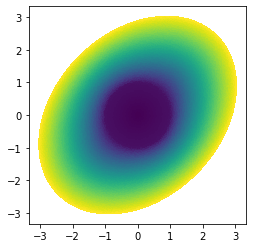

In [895]:
# Execute this to obtain the plot of the analytical solution
V_ref = dolfin.VectorFunctionSpace(mesh, 'P', 2)
u_ref_num = dolfin.interpolate(u_ref, V_ref)
dolfin.plot(0.15*u_ref_num, mode="displacement")

# 14)Compute the L2 error norm of the numerical solution

In [896]:
erreur_L2 = assemble(dot(usol,usol)*dx) - assemble(2*dot(usol,u_ref_num)*dx) + assemble(dot(u_ref_num,u_ref_num)*dx)
print(erreur_L2/assemble(dot(u_ref,u_ref)*dx))

# à calculer pour une fraction h/R_in afin de tracer le graphique de convergence

2.726218128847437e-10


# 15) Plot $u_y(x,0)$ for both the analytical and numerical solution

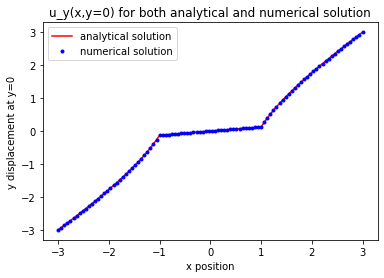

In [822]:
liste_x = np.linspace(-R_out, R_out, num=100)

u_formule = 0.0*liste_x
u_formule_simu = 0.0*liste_x

for k, x_k in enumerate(liste_x):
    u_formule[k] = u_ref([x_k,0.0])[1]
    u_formule_simu[k] = usol([x_k,0.0])[1]

plt.xlabel('x position')
plt.ylabel('y displacement at y=0')
plt.title('u_y(x,y=0) for both analytical and numerical solution')
plt.plot(liste_x, u_formule, label='analytical solution', color='red')
plt.plot(liste_x, u_formule_simu, '.', label='numerical solution', color='blue')
plt.legend()
plt.show()

# 16) Put a legend, axis labels, and title to this plot. Plot each curve with a different color

In [ ]:
# done at question 15